In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pwd

In [ ]:
cd ..

In [4]:
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.dataset import GeneExpressionDataset

from src.test.Second_predict import prepare_potential_reps # RepresentationLayer import in predict.py?
from src.test.Second_predict import learn_new_representation

In [5]:
print(torch.__version__)

2.4.1+cu121


## For standard DGD

In [6]:
# set random seeds, device and data directory
seed = 1
set_seed(seed)
#num_workers # add to the data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # add gpu to node request

In [7]:
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU")

GPU name: No GPU


In [ ]:
# set directory for output files
os.chdir('/path/to...')

In [9]:
# Read data, only HMF
# mut_data = pd.read_csv("SNV_mutation_catalogue_HMF.tsv", sep='\t')

In [10]:
# mut_data = mut_data.iloc[:, 3:] # from column index 3

In [11]:
# we want the data including the tissue type. The "i" column is the original index (a few samples are removed as they werent compatible in the ID)
# mut_data = pd.read_csv("to_dgd.tsv", sep='\t') # 11.08 on GPU 128g and 16 cores
# > 30 min with 500g and 16 cores CPU

In [12]:
#import pyarrow.csv as pv

#table = pv.read_csv("to_dgd.tsv", parse_options=pv.ParseOptions(delimiter="\t"))
#mut_data = table.to_pandas()

In [13]:
#mut_data = pd.read_csv("to_dgd.tsv", sep='\t', engine="pyarrow")

In [14]:
mut_data = pd.read_parquet("to_dgd.parquet") # 15 sec on CPU
# 40 sec on GPU

In [15]:
mut_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,12,6,5,11,7,4,2,6,2,0,...,2,7,4,5,7,12,5,3,13,Breast-AdenoCa
DO1002,20,4,6,5,11,9,0,4,3,2,...,3,4,0,6,6,6,1,2,7,Breast-AdenoCa
DO1003,13,4,7,6,3,6,0,9,2,0,...,2,6,3,1,6,5,3,3,8,Breast-AdenoCa
DO1004,34,11,19,24,33,13,3,20,2,1,...,11,9,7,10,12,5,7,6,17,Breast-AdenoCa
DO1005,9,5,5,7,9,10,3,9,0,0,...,3,3,3,2,3,5,4,2,4,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9700,51,14,40,43,47,17,2,29,4,0,...,4,19,7,14,13,47,27,13,80,ColoRect-AdenoCA
DO9732,76,21,24,47,39,28,0,22,5,3,...,5,9,6,14,15,17,27,12,48,ColoRect-AdenoCA
DO9788,59,10,25,26,26,16,2,20,7,2,...,4,14,6,7,13,39,27,18,65,ColoRect-AdenoCA


In [16]:
# no NaNs
mut_data.isna().sum().sum()

np.int64(0)

In [17]:
# split into train and val/test data
train_data, val_test_data = train_test_split(mut_data, test_size=0.3, random_state=seed, stratify=mut_data['Tumor_Type'])

In [18]:
train_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,21,8,7,10,14,4,2,10,2,0,...,2,2,0,2,2,3,4,3,12,Prost-AdenoCA
DO52701,8,3,4,6,5,5,0,5,0,0,...,4,2,0,1,5,10,9,2,27,Lymph-CLL
DO51500,23,4,5,9,17,7,1,1,1,0,...,3,2,0,4,1,9,7,2,14,Panc-AdenoCA
DO10829,3,3,3,1,5,1,0,2,0,1,...,0,0,0,1,1,0,1,0,3,Prost-AdenoCA
DO51069,10,3,4,5,4,5,0,1,0,0,...,2,1,0,0,2,2,1,0,6,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,19,10,8,9,15,5,0,5,2,2,...,1,3,1,0,4,3,4,2,10,Liver-HCC
DO6474,5,3,4,1,0,0,0,3,1,0,...,0,0,0,2,2,0,0,1,3,Lymph-CLL
DO48952,1,0,0,2,0,1,1,1,0,0,...,0,3,1,0,1,0,0,1,2,CNS-Medullo


In [19]:
# no. batches
1744/64

27.25

In [20]:
label_counts = train_data['Tumor_Type'].value_counts()
len(label_counts)

27

In [21]:
validation_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed, stratify=val_test_data['Tumor_Type'])

In [22]:
validation_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50837,9,3,4,3,3,4,1,2,0,0,...,1,0,1,0,0,1,0,0,7,Liver-HCC
DO9074,80,18,43,52,36,30,3,14,2,0,...,2,2,1,6,2,9,5,2,35,ColoRect-AdenoCA
DO15398,53,14,17,32,26,18,0,10,2,0,...,5,13,3,5,10,15,4,15,36,Head-SCC
DO46744,5,1,2,0,2,2,0,0,0,0,...,0,0,0,0,1,1,2,0,4,Panc-Endocrine
DO49768,15,2,2,7,7,3,0,7,1,1,...,9,0,3,0,6,12,6,2,28,Kidney-RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,14,1,7,7,13,5,2,7,0,0,...,3,3,2,3,3,4,5,5,17,Ovary-AdenoCA
DO23028,38,16,26,19,26,14,3,32,4,6,...,6,3,3,4,2,7,7,7,14,Liver-HCC
DO48925,2,0,0,2,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,CNS-Medullo


In [23]:
# dimensions for features
out_dim = train_data.shape[1]-1
out_dim

1536

In [24]:
# I'll call it validation loader for now
# train_ratio = 0.9
# train_data = train_val_data .iloc[:int(train_ratio*len(train_val_data )),:]
# validation_data = train_val_data .iloc[int(train_ratio*len(train_val_data )):,:]

#train_data, validation_data = train_test_split(train_val_data, test_size=0.1, random_state=seed, stratify=train_val_data[primaryTumorLocation])

# define scaling for NB
# each sample gets a scaling factor
# scaling factors already built in in Dataset
# scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# validation_scaling_factors = torch.mean(torch.Tensor(validation_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data, scaling_type="sum"),
                                          batch_size=64,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(GeneExpressionDataset(validation_data, scaling_type="sum"),
                                          batch_size=64,
                                          shuffle=False)

# The class GeneExpressionDataset also works for samples x mut_type (row x column)

In [25]:
train_loader.dataset.data

tensor([[21.,  8.,  7.,  ...,  4.,  3., 12.],
        [ 8.,  3.,  4.,  ...,  9.,  2., 27.],
        [23.,  4.,  5.,  ...,  7.,  2., 14.],
        ...,
        [ 1.,  0.,  0.,  ...,  0.,  1.,  2.],
        [15.,  4.,  4.,  ...,  2.,  2., 11.],
        [23.,  8.,  5.,  ...,  6.,  3., 24.]])

In [26]:
n_tissues = len(mut_data["Tumor_Type"].unique())
n_tissues

27

In [27]:
# hyperparameters
latent_dim = 20
hidden_dims = [100, 100, 100]
reduction_type = "sum" # output loss reduction

In [28]:
# decoder setup

# set up an output module for the mutation data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim) # input and output (mutation counts) for the last layer
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="sum") # negative binomial of final output
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_gex_layer]).to(device)

In [29]:
palette = {
    "Biliary-AdenoCA": "#00CD66",
    "Bladder-TCC": "#EEAD0E",
    "Bone-Epith": "#ADAC44",
    "Bone-Leiomyo": "green", # I added
    "Bone-Osteosarc": "#FFD700",
    "Breast-AdenoCa": "#CD6090",
    "CNS-GBM": "#3D3D3D",
    "CNS-Medullo": "#D8BFD8",
    "CNS-Oligo": "#787878",
    "CNS-PiloAstro": "#B0B0B0",
    "Cervix-SCC": "#79CDCD",
    "ColoRect-AdenoCA": "#191970",
    "Eso-AdenoCa": "#1E90FF",
    "Head-SCC": "#8B2323",
    "Kidney-ChRCC": "#B32F0B",
    "Kidney-RCC": "#FF4500",
    "Liver-HCC": "#006400",
    "Lung-AdenoCA": "pink",
    "Lung-SCC": "#FDF5E6",
    "Lymph-BNHL": "#698B22",
    "Lymph-CLL": "#F4A35D", # found the right one
    "Myeloid-AML": "#CD6600",
    "Myeloid-MPN": "#FFC100",
    "Ovary-AdenoCA": "#008B8B",
    "Panc-AdenoCA": "#7A378B",
    "Panc-Endocrine": "#E066FF",
    "Prost-AdenoCA": "#87CEFA",
    "Skin-Melanoma": "#000000",
    "SoftTissue-Leiomyo": "#FFEC8B",
    "SoftTissue-Liposarc": "#CDCB50",
    "Stomach-AdenoCA": "#BFEFFF",
    "Thy-AdenoCA": "#9370DB",
    "Uterus-AdenoCA": "#FF8C69"
}

In [30]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,rep_dim,gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim = rep_dim      # Dimension of representation

        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None
        self.test_rep=None

    def forward(self,z):
        return self.decoder(z)

    def loss(self,z,y,target,scale,gmm_loss=True,reduction="sum"):
        self.dec_loss = self.decoder.loss(y,target,scale,reduction=reduction)
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
            return self.dec_loss, self.gmm_loss
        else:
            return self.dec_loss, None
    
    def forward_and_loss(self,z,target,scale,gmm_loss=True,reduction="sum"):
        y = self.decoder(z)
        return self.loss(z,y,target,scale,gmm_loss,reduction)
    
    def get_representations(self, type="train"):   # The one I use. Detached from the computation graph. 
        if type=="train":
            return self.train_rep.z.detach().cpu().numpy()
        elif type=="val":
            return self.val_rep.z.detach().cpu().numpy()
        elif type=="test":
            return self.test_rep.z.detach().cpu().numpy()
    
    def get_gmm_means(self):
        return self.gmm.mean.detach().cpu().numpy()
    
    def get_latent_space_values(self, rep_type="train", n_samples=1000): # Cloned and isolated from the original tensors
        # get representations
        if rep_type=="train":
            rep = self.train_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="val":
            rep = self.val_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="test":
            rep = self.test_rep.z.clone().detach().cpu().numpy()
        
        # get gmm means
        gmm_means = self.gmm.mean.clone().detach().cpu().numpy()

        # get some gmm samples
        gmm_samples = self.gmm.sample(n_samples).detach().cpu().numpy()

        return rep, gmm_means, gmm_samples

In [31]:
# write a minimal training function

def train_dgd(dgd, train_loader, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,plot=10,reduction_type="sum"):
    if reduction_type == "sum":
        tlen=len(train_loader.dataset)*dgd.decoder.n_out_features
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)*dgd.decoder.n_out_features
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
    else:
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)
    
    Ntrain=len(train_loader.dataset)
    Nvalidation=len(validation_loader.dataset)
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device)
    Nvalidation=len(validation_loader.dataset)
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'], weight_decay=weight_decay) # add weight_decay
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[]}
    best_loss=1.e20
    gmm_loss=True

    for epoch in range(nepochs): # also uses library. Doesn't find the best gmm for initial reps like in predict.py as they haven't been trained yet
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)
        train_rep_optimizer.zero_grad()
        dgd.train()
        for x, lib, index in train_loader:
            dec_optimizer.zero_grad()
            if gmm_loss: gmm_optimizer.zero_grad()
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.train_rep(index).to(device),[x.to(device)],[lib.unsqueeze(1).to(device)], # added to.(device)
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
            dec_optimizer.step()
            if gmm_loss: gmm_optimizer.step()
            #return None
        train_rep_optimizer.step()

        loss_tab["Train recon"][-1] /= tlen
        loss_tab["GMM train"][-1] /= tlen_gmm

        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()
        
        dgd.eval()
        
        for x, lib, index in validation_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.val_rep(index).to(device),[x.to(device)],[lib.unsqueeze(1).to(device)], # added to.(device)
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
        val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm

        if pr>0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
        if plot>0 and (epoch+1)%plot==0:
            plot_latent_space(*dgd.get_latent_space_values("train",1000),train_loader.dataset.label,epoch)
    
    return loss_tab

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)

    # Calculate variance explained
    var_exp = pca.explained_variance_ratio_ * 100  # convert to percentage
    pc1_label = f"PC1 ({var_exp[0]:.1f}%)"
    pc2_label = f"PC2 ({var_exp[1]:.1f}%)"
    
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].set_xlabel(pc1_label)
    ax[0].set_ylabel(pc2_label)
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # second plot: representations colored by labels
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", s=1, alpha=0.8, ax=ax[1], hue="label", palette=palette) 
    ax[1].set_title("E"+str(epoch)+": Latent space (by label)")
    ax[1].set_xlabel(pc1_label)
    ax[1].set_ylabel(pc2_label)
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)

    plt.savefig(f"PiB_latent_space_epoch_{epoch}.pdf", bbox_inches='tight', dpi=300)
    
    plt.show()

In [32]:
# init a DGD model

gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # 0.2 is empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1), "weight_alpha": 1}
)

In [33]:
sd_mean_init

0.037037037037037035

100 epochs takes around 15 min.
Slower when I explicitly add num_workers and increase ressourches to 500g and 32 cores.
Chat says that with large datasets, multiple workers may create excessive memory overhead.
With 8 workers: 20 min for 30 epochs.

19 min for 100 epochs with latent dim of 50

For 1000 neuron layers and latent 20, 10 epochs take 2 min

For 1000 neuron layers and latent 50, 10 epochs take 4 min

200 1.8824373224824211 1.8750071534073502


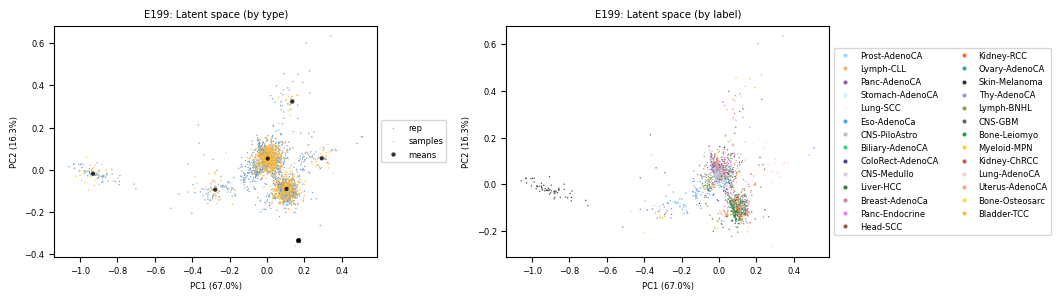

400 1.8274844283357672 1.8217068160493957


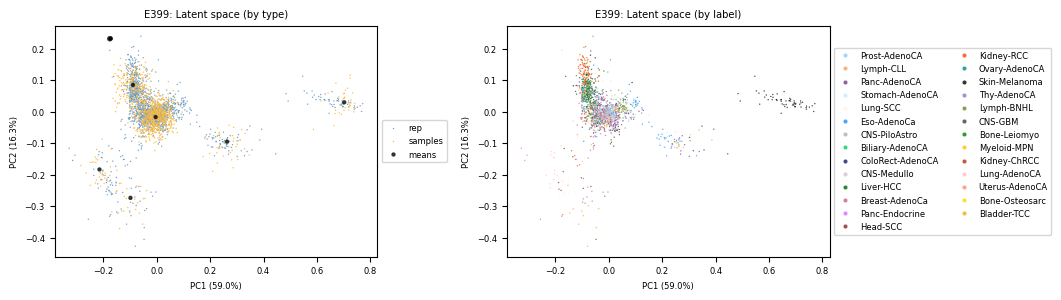

600 1.7880180633031628 1.7843726663028492


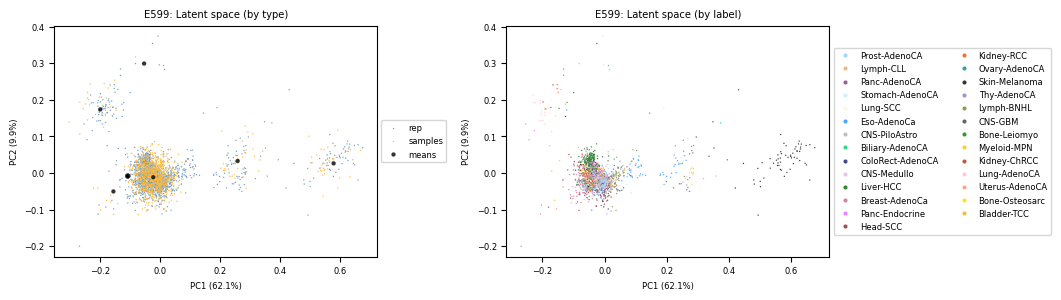

800 1.7591938928726616 1.7575203526678782


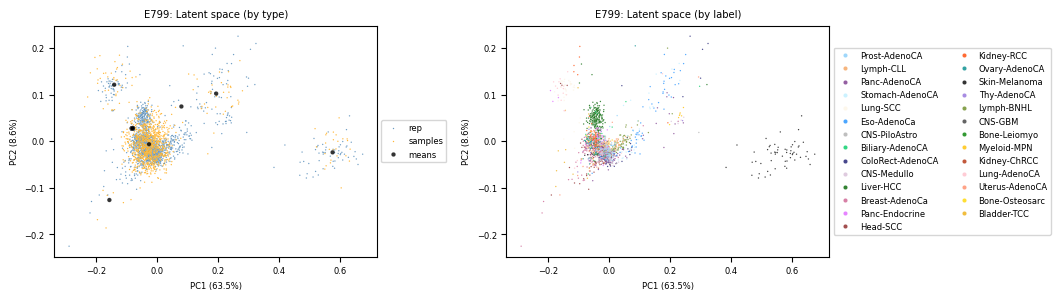

1000 1.739005339619581 1.739619807551039


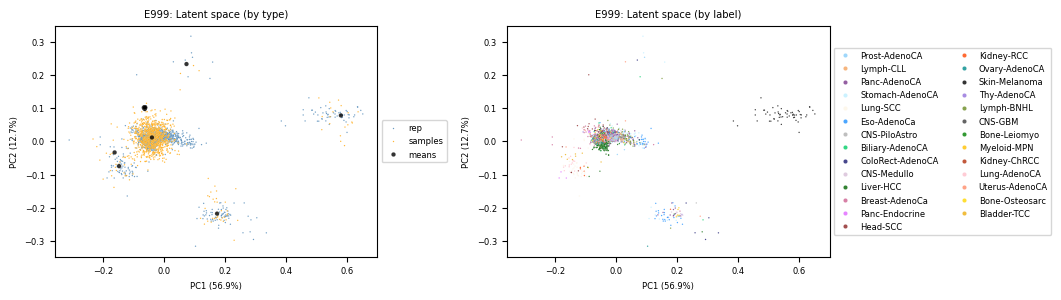

1200 1.7226650080549608 1.7253637194845979


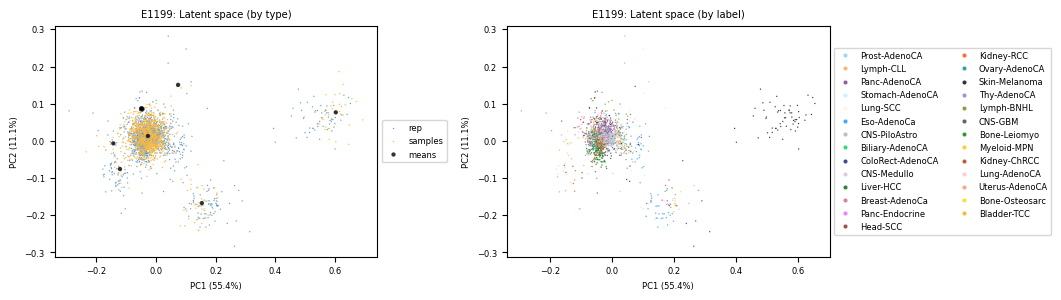

1400 1.711371376609219 1.71672077144956


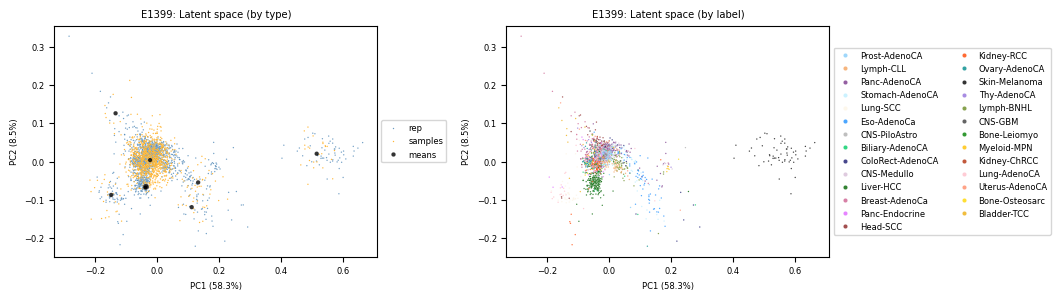

1600 1.7036677748420552 1.7116842830882353


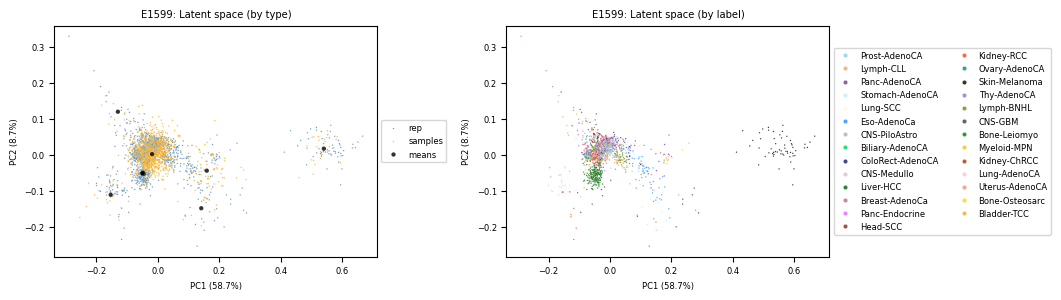

1800 1.6982443485784968 1.7090764445204574


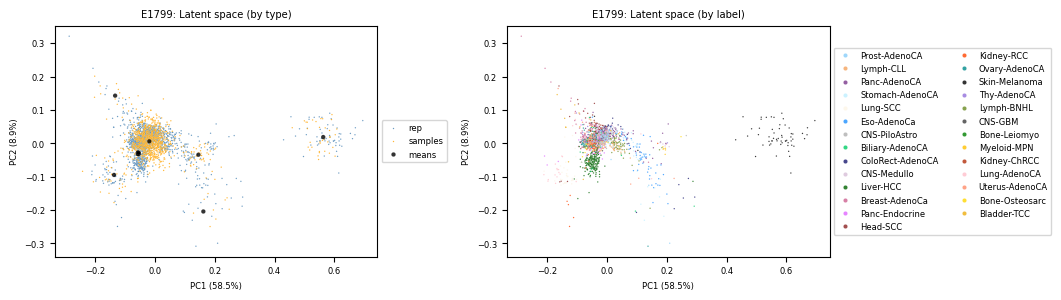

2000 1.6939996346056643 1.7072284990878455


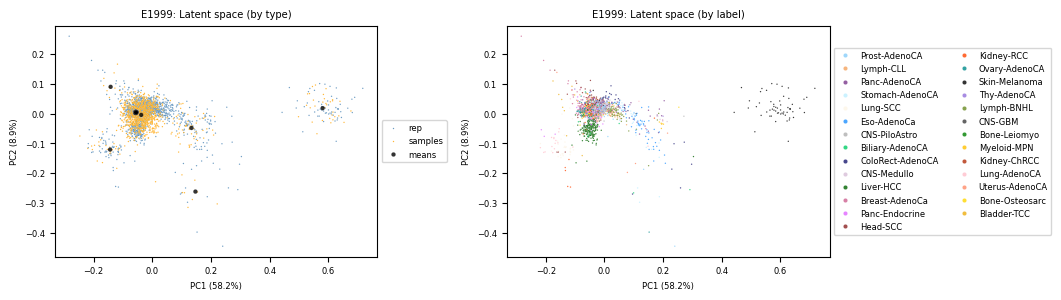

In [34]:
# train for x epochs and plot learning curves
n_epochs = 2000
pr = 200 # how often to print loss
plot = 200

loss_tab = train_dgd(
    dgd, train_loader, validation_loader, device, 
    learning_rates={'dec':0.0001,'rep':0.01,'gmm':0.01},
    weight_decay=0.1,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )

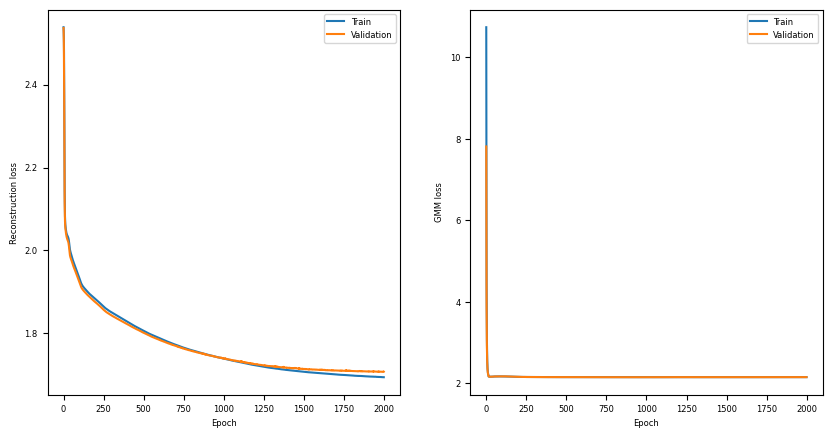

In [35]:
# make 2 subplots with recon and gmm loss curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()

plt.savefig(f"PiB_learning_curves.pdf", dpi=300)

plt.show()

In [36]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=100, out_features=1536, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [37]:
# save the trained model
torch.save(dgd, "PiB_dgd_model_2.pth")

# Test representation

In [102]:
dgd_model = torch.load("PiB_dgd_model_2.pth")

/tmp/62405063/ipykernel_1574913/15054855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dgd_model = torch.load("PiB_dgd_model_2.pth")


In [103]:
#dgd_model = torch.load("dgd_model_1.pth", map_location=torch.device('cpu'))

In [104]:
dgd_model

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=100, out_features=1536, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [105]:
# take test part of mut_data
#test_data = mut_data.loc[X_test.index]
test_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,14,3,4,5,8,6,0,5,0,0,...,3,0,1,2,0,0,2,0,8,Prost-AdenoCA
DO51496,14,3,8,11,11,5,0,7,1,1,...,2,2,0,1,1,2,2,2,9,Panc-AdenoCA
DO15046,81,38,65,75,49,33,7,41,7,5,...,8,10,14,7,8,13,20,11,64,Head-SCC
DO6558,7,2,0,3,2,0,1,0,2,0,...,0,0,1,0,1,0,0,1,3,Lymph-CLL
DO50410,48,10,38,27,38,22,1,22,4,1,...,7,16,3,8,7,171,92,78,143,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,42,18,21,19,31,15,4,32,4,2,...,2,10,6,13,6,7,2,8,18,Ovary-AdenoCA
DO51514,13,8,11,10,7,10,0,7,1,0,...,0,3,0,8,4,9,6,8,25,Panc-AdenoCA
DO51144,16,2,6,3,10,4,0,8,0,0,...,0,2,0,0,0,2,3,1,10,Prost-AdenoCA


In [106]:
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data, scaling_type="sum"), # default is scaling_type='mean'
                                          batch_size=64,
                                          shuffle=False)

In [107]:
# Access the first sample (idx=0)
#mutations, lib, idx = see_test[0] 

# Print the results
#print("Mutations:", mutations)
#print("Library Size (lib):", lib)
#print("Index:", idx)

In [108]:
test_loader.dataset

In [109]:
# 80 sec
new_rep = learn_new_representation(dgd_model, 
                             test_loader,
                             test_epochs=50,
                             learning_rates=1e-2,
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="sum",
                             resampling_type="mean")

100%|██████████| 50/50 [00:02<00:00, 20.65it/s]


In [110]:
new_rep

RepresentationLayer()

In [111]:
dgd_model.train_rep

RepresentationLayer()

In [112]:
# assign the test representation from the predict function to the test_rep in the dgd model
dgd_model.test_rep = new_rep

In [113]:
dgd_test = dgd_model.get_representations(type="test")
dgd_test

array([[-0.01383796,  0.09306855,  0.02116597, ..., -0.03347759,
        -0.09028599, -0.10401769],
       [-0.0192397 ,  0.09384108,  0.06988886, ..., -0.11425043,
        -0.09201796, -0.11247843],
       [ 0.03984892,  0.09129529, -0.00629267, ..., -0.05581579,
        -0.11141004, -0.09683581],
       ...,
       [-0.02503913,  0.10644015,  0.04107663, ..., -0.05099478,
        -0.1079552 , -0.09128161],
       [ 0.0288367 ,  0.11987612,  0.03726667, ..., -0.08811459,
        -0.12645201, -0.06044305],
       [-0.0115105 ,  0.09747855,  0.0321071 , ..., -0.07784518,
        -0.11390257, -0.08835008]], dtype=float32)

In [114]:
# make df with latent variable column names
dgd_test_df = pd.DataFrame(dgd_test, columns = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,-0.013838,0.093069,0.021166,0.021296,-0.078245,-0.010285,-0.107692,0.044616,-0.037027,0.120422,-0.075072,0.051588,0.014916,-0.128250,-0.057389,0.153127,-0.157456,-0.033478,-0.090286,-0.104018
1,-0.019240,0.093841,0.069889,0.053766,-0.090037,-0.077791,-0.072679,0.057439,-0.037833,0.123494,-0.043275,0.104515,0.033426,-0.122898,-0.064621,0.111891,-0.119210,-0.114250,-0.092018,-0.112478
2,0.039849,0.091295,-0.006293,0.000343,-0.072743,0.015058,-0.080456,0.078507,-0.028534,0.112229,-0.110835,0.033320,0.006062,-0.104377,-0.029149,0.158485,-0.177944,-0.055816,-0.111410,-0.096836
3,0.017059,0.103978,0.011385,0.009828,-0.075071,-0.008252,-0.118700,0.058395,-0.058049,0.136869,-0.083131,0.070241,0.038246,-0.137488,-0.052383,0.159963,-0.169704,-0.063003,-0.110672,-0.113433
4,-0.089074,0.101532,0.115593,0.022823,-0.091547,-0.068581,-0.114145,-0.096488,-0.051470,0.163129,0.065552,0.126399,0.018310,-0.277845,-0.082309,0.161371,-0.177601,-0.097735,-0.089164,-0.122386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,-0.019506,0.093131,0.023973,-0.003382,-0.099245,0.038810,-0.092915,0.061651,-0.030316,0.117641,-0.091350,0.058067,0.000016,-0.140121,-0.034654,0.152379,-0.158509,-0.060443,-0.118114,-0.095693
370,-0.001969,0.107460,0.041399,0.063867,-0.069346,-0.028917,-0.110061,0.063863,-0.040082,0.108436,-0.087567,0.012763,0.039574,-0.118685,-0.062995,0.136561,-0.151046,-0.070171,-0.087314,-0.087934
371,-0.025039,0.106440,0.041077,0.024390,-0.088767,-0.014511,-0.102345,0.059666,-0.048731,0.120619,-0.089094,0.055149,0.019271,-0.137891,-0.060363,0.155629,-0.166244,-0.050995,-0.107955,-0.091282
372,0.028837,0.119876,0.037267,-0.005674,-0.036805,0.017913,-0.111433,0.042245,-0.041149,0.126774,-0.082361,0.067394,-0.007968,-0.153545,-0.084311,0.131354,-0.162196,-0.088115,-0.126452,-0.060443


In [115]:
test_data['Tumor_Type']

Donor_ID
DO51074    Prost-AdenoCA
DO51496     Panc-AdenoCA
DO15046         Head-SCC
DO6558         Lymph-CLL
DO50410      Eso-AdenoCa
               ...      
DO46400    Ovary-AdenoCA
DO51514     Panc-AdenoCA
DO51144    Prost-AdenoCA
DO23551        Liver-HCC
DO31420    Ovary-AdenoCA
Name: Tumor_Type, Length: 374, dtype: object

In [116]:
# add Donor_ID again
dgd_test_df.index = test_data.index
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO51074,-0.013838,0.093069,0.021166,0.021296,-0.078245,-0.010285,-0.107692,0.044616,-0.037027,0.120422,-0.075072,0.051588,0.014916,-0.128250,-0.057389,0.153127,-0.157456,-0.033478,-0.090286,-0.104018
DO51496,-0.019240,0.093841,0.069889,0.053766,-0.090037,-0.077791,-0.072679,0.057439,-0.037833,0.123494,-0.043275,0.104515,0.033426,-0.122898,-0.064621,0.111891,-0.119210,-0.114250,-0.092018,-0.112478
DO15046,0.039849,0.091295,-0.006293,0.000343,-0.072743,0.015058,-0.080456,0.078507,-0.028534,0.112229,-0.110835,0.033320,0.006062,-0.104377,-0.029149,0.158485,-0.177944,-0.055816,-0.111410,-0.096836
DO6558,0.017059,0.103978,0.011385,0.009828,-0.075071,-0.008252,-0.118700,0.058395,-0.058049,0.136869,-0.083131,0.070241,0.038246,-0.137488,-0.052383,0.159963,-0.169704,-0.063003,-0.110672,-0.113433
DO50410,-0.089074,0.101532,0.115593,0.022823,-0.091547,-0.068581,-0.114145,-0.096488,-0.051470,0.163129,0.065552,0.126399,0.018310,-0.277845,-0.082309,0.161371,-0.177601,-0.097735,-0.089164,-0.122386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,-0.019506,0.093131,0.023973,-0.003382,-0.099245,0.038810,-0.092915,0.061651,-0.030316,0.117641,-0.091350,0.058067,0.000016,-0.140121,-0.034654,0.152379,-0.158509,-0.060443,-0.118114,-0.095693
DO51514,-0.001969,0.107460,0.041399,0.063867,-0.069346,-0.028917,-0.110061,0.063863,-0.040082,0.108436,-0.087567,0.012763,0.039574,-0.118685,-0.062995,0.136561,-0.151046,-0.070171,-0.087314,-0.087934
DO51144,-0.025039,0.106440,0.041077,0.024390,-0.088767,-0.014511,-0.102345,0.059666,-0.048731,0.120619,-0.089094,0.055149,0.019271,-0.137891,-0.060363,0.155629,-0.166244,-0.050995,-0.107955,-0.091282


In [117]:
# add tumor type, the sample order is preserved
dgd_test_df['Tumor_Type'] = test_data['Tumor_Type']
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,-0.013838,0.093069,0.021166,0.021296,-0.078245,-0.010285,-0.107692,0.044616,-0.037027,0.120422,...,0.051588,0.014916,-0.128250,-0.057389,0.153127,-0.157456,-0.033478,-0.090286,-0.104018,Prost-AdenoCA
DO51496,-0.019240,0.093841,0.069889,0.053766,-0.090037,-0.077791,-0.072679,0.057439,-0.037833,0.123494,...,0.104515,0.033426,-0.122898,-0.064621,0.111891,-0.119210,-0.114250,-0.092018,-0.112478,Panc-AdenoCA
DO15046,0.039849,0.091295,-0.006293,0.000343,-0.072743,0.015058,-0.080456,0.078507,-0.028534,0.112229,...,0.033320,0.006062,-0.104377,-0.029149,0.158485,-0.177944,-0.055816,-0.111410,-0.096836,Head-SCC
DO6558,0.017059,0.103978,0.011385,0.009828,-0.075071,-0.008252,-0.118700,0.058395,-0.058049,0.136869,...,0.070241,0.038246,-0.137488,-0.052383,0.159963,-0.169704,-0.063003,-0.110672,-0.113433,Lymph-CLL
DO50410,-0.089074,0.101532,0.115593,0.022823,-0.091547,-0.068581,-0.114145,-0.096488,-0.051470,0.163129,...,0.126399,0.018310,-0.277845,-0.082309,0.161371,-0.177601,-0.097735,-0.089164,-0.122386,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,-0.019506,0.093131,0.023973,-0.003382,-0.099245,0.038810,-0.092915,0.061651,-0.030316,0.117641,...,0.058067,0.000016,-0.140121,-0.034654,0.152379,-0.158509,-0.060443,-0.118114,-0.095693,Ovary-AdenoCA
DO51514,-0.001969,0.107460,0.041399,0.063867,-0.069346,-0.028917,-0.110061,0.063863,-0.040082,0.108436,...,0.012763,0.039574,-0.118685,-0.062995,0.136561,-0.151046,-0.070171,-0.087314,-0.087934,Panc-AdenoCA
DO51144,-0.025039,0.106440,0.041077,0.024390,-0.088767,-0.014511,-0.102345,0.059666,-0.048731,0.120619,...,0.055149,0.019271,-0.137891,-0.060363,0.155629,-0.166244,-0.050995,-0.107955,-0.091282,Prost-AdenoCA


In [118]:
# save test reps for KNN
dgd_test_df.to_csv('Second_PiB_dgd_test_df.tsv', sep='\t', index=True)

In [119]:
print(dgd_model.test_rep)


        RepresentationLayer:
            Dimensionality: 20
            Number of samples: 374
            Value initialization: custom
        


# Train/val rep df for KNN

In [120]:
# check the saved coordinates are the same, they are
dgd_train = dgd_model.get_representations(type="train")
dgd_train

array([[-0.02064113,  0.10402012,  0.0318166 , ..., -0.05322526,
        -0.10110231, -0.10838538],
       [-0.01485358,  0.1082506 ,  0.02800254, ..., -0.07068051,
        -0.12762214, -0.0972057 ],
       [-0.01333349,  0.10577167,  0.0443783 , ..., -0.064154  ,
        -0.09020321, -0.08480746],
       ...,
       [-0.01818367,  0.10346509,  0.04291792, ..., -0.07337587,
        -0.11220166, -0.09302133],
       [ 0.01095327,  0.09317601,  0.02112087, ..., -0.04912561,
        -0.07544917, -0.09094378],
       [-0.00909668,  0.0976479 ,  0.03421433, ..., -0.06683316,
        -0.11208973, -0.06382125]], dtype=float32)

In [121]:
# make df with latent variable column names
dgd_train_df = pd.DataFrame(dgd_train, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,-0.020641,0.104020,0.031817,0.043219,-0.105376,-0.010312,-0.108356,0.048119,-0.045231,0.127033,-0.071515,0.071361,0.015520,-0.133740,-0.060531,0.146974,-0.155402,-0.053225,-0.101102,-0.108385
1,-0.014854,0.108251,0.028003,0.000962,-0.080837,-0.041878,-0.108884,-0.014919,-0.094988,0.139641,-0.035572,0.045273,0.032418,-0.144925,-0.009707,0.173092,-0.184112,-0.070681,-0.127622,-0.097206
2,-0.013333,0.105772,0.044378,0.054269,-0.069551,-0.018984,-0.105490,0.057692,-0.026825,0.115697,-0.081518,0.043088,0.050751,-0.124817,-0.071293,0.142057,-0.155656,-0.064154,-0.090203,-0.084807
3,-0.025626,0.102850,0.037042,0.021037,-0.083831,-0.031817,-0.100075,0.053068,-0.047876,0.122326,-0.088140,0.060236,0.027094,-0.128570,-0.066060,0.145995,-0.155661,-0.030989,-0.087139,-0.089242
4,-0.033500,0.102799,0.034542,0.018281,-0.079239,-0.019522,-0.102130,0.049913,-0.029781,0.120148,-0.090251,0.054020,0.016957,-0.127692,-0.077901,0.148597,-0.154558,-0.004026,-0.071676,-0.098095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.000478,0.103263,0.017978,-0.006737,-0.057599,0.014319,-0.117397,0.042214,-0.034826,0.127990,-0.075129,0.064337,0.033753,-0.131524,-0.070077,0.152195,-0.161393,-0.031428,-0.086323,-0.107286
1740,-0.003654,0.099951,0.016583,0.034390,-0.046666,0.033525,-0.113618,0.053559,-0.044316,0.121140,-0.075427,0.071375,0.030140,-0.127634,-0.063995,0.144475,-0.153939,-0.047464,-0.094844,-0.100468
1741,-0.018184,0.103465,0.042918,0.033004,-0.103004,-0.001659,-0.095587,0.066663,-0.044886,0.120714,-0.087354,0.071014,0.015548,-0.134826,-0.060773,0.141942,-0.156293,-0.073376,-0.112202,-0.093021
1742,0.010953,0.093176,0.021121,0.054136,-0.082815,0.013153,-0.102562,0.083930,-0.025742,0.111696,-0.097345,0.061823,0.074052,-0.112672,-0.076773,0.135469,-0.144240,-0.049126,-0.075449,-0.090944


In [122]:
# add Donor_ID again
dgd_train_df.index = train_data.index
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO50420,-0.020641,0.104020,0.031817,0.043219,-0.105376,-0.010312,-0.108356,0.048119,-0.045231,0.127033,-0.071515,0.071361,0.015520,-0.133740,-0.060531,0.146974,-0.155402,-0.053225,-0.101102,-0.108385
DO52701,-0.014854,0.108251,0.028003,0.000962,-0.080837,-0.041878,-0.108884,-0.014919,-0.094988,0.139641,-0.035572,0.045273,0.032418,-0.144925,-0.009707,0.173092,-0.184112,-0.070681,-0.127622,-0.097206
DO51500,-0.013333,0.105772,0.044378,0.054269,-0.069551,-0.018984,-0.105490,0.057692,-0.026825,0.115697,-0.081518,0.043088,0.050751,-0.124817,-0.071293,0.142057,-0.155656,-0.064154,-0.090203,-0.084807
DO10829,-0.025626,0.102850,0.037042,0.021037,-0.083831,-0.031817,-0.100075,0.053068,-0.047876,0.122326,-0.088140,0.060236,0.027094,-0.128570,-0.066060,0.145995,-0.155661,-0.030989,-0.087139,-0.089242
DO51069,-0.033500,0.102799,0.034542,0.018281,-0.079239,-0.019522,-0.102130,0.049913,-0.029781,0.120148,-0.090251,0.054020,0.016957,-0.127692,-0.077901,0.148597,-0.154558,-0.004026,-0.071676,-0.098095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,0.000478,0.103263,0.017978,-0.006737,-0.057599,0.014319,-0.117397,0.042214,-0.034826,0.127990,-0.075129,0.064337,0.033753,-0.131524,-0.070077,0.152195,-0.161393,-0.031428,-0.086323,-0.107286
DO6474,-0.003654,0.099951,0.016583,0.034390,-0.046666,0.033525,-0.113618,0.053559,-0.044316,0.121140,-0.075427,0.071375,0.030140,-0.127634,-0.063995,0.144475,-0.153939,-0.047464,-0.094844,-0.100468
DO48952,-0.018184,0.103465,0.042918,0.033004,-0.103004,-0.001659,-0.095587,0.066663,-0.044886,0.120714,-0.087354,0.071014,0.015548,-0.134826,-0.060773,0.141942,-0.156293,-0.073376,-0.112202,-0.093021


In [123]:
# add tissue, the sample order is preserved
dgd_train_df['Tumor_Type'] = train_data['Tumor_Type']
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,-0.020641,0.104020,0.031817,0.043219,-0.105376,-0.010312,-0.108356,0.048119,-0.045231,0.127033,...,0.071361,0.015520,-0.133740,-0.060531,0.146974,-0.155402,-0.053225,-0.101102,-0.108385,Prost-AdenoCA
DO52701,-0.014854,0.108251,0.028003,0.000962,-0.080837,-0.041878,-0.108884,-0.014919,-0.094988,0.139641,...,0.045273,0.032418,-0.144925,-0.009707,0.173092,-0.184112,-0.070681,-0.127622,-0.097206,Lymph-CLL
DO51500,-0.013333,0.105772,0.044378,0.054269,-0.069551,-0.018984,-0.105490,0.057692,-0.026825,0.115697,...,0.043088,0.050751,-0.124817,-0.071293,0.142057,-0.155656,-0.064154,-0.090203,-0.084807,Panc-AdenoCA
DO10829,-0.025626,0.102850,0.037042,0.021037,-0.083831,-0.031817,-0.100075,0.053068,-0.047876,0.122326,...,0.060236,0.027094,-0.128570,-0.066060,0.145995,-0.155661,-0.030989,-0.087139,-0.089242,Prost-AdenoCA
DO51069,-0.033500,0.102799,0.034542,0.018281,-0.079239,-0.019522,-0.102130,0.049913,-0.029781,0.120148,...,0.054020,0.016957,-0.127692,-0.077901,0.148597,-0.154558,-0.004026,-0.071676,-0.098095,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,0.000478,0.103263,0.017978,-0.006737,-0.057599,0.014319,-0.117397,0.042214,-0.034826,0.127990,...,0.064337,0.033753,-0.131524,-0.070077,0.152195,-0.161393,-0.031428,-0.086323,-0.107286,Liver-HCC
DO6474,-0.003654,0.099951,0.016583,0.034390,-0.046666,0.033525,-0.113618,0.053559,-0.044316,0.121140,...,0.071375,0.030140,-0.127634,-0.063995,0.144475,-0.153939,-0.047464,-0.094844,-0.100468,Lymph-CLL
DO48952,-0.018184,0.103465,0.042918,0.033004,-0.103004,-0.001659,-0.095587,0.066663,-0.044886,0.120714,...,0.071014,0.015548,-0.134826,-0.060773,0.141942,-0.156293,-0.073376,-0.112202,-0.093021,CNS-Medullo


Validation set

In [124]:
# DGD coordinates for validation data
dgd_val = dgd_model.get_representations(type="val")
dgd_val

array([[ 0.00510563,  0.10521945,  0.01918625, ..., -0.05367302,
        -0.09481477, -0.10620022],
       [-0.00218727,  0.11356628,  0.06632201, ..., -0.08216722,
        -0.11335181, -0.09348451],
       [ 0.0081043 ,  0.09458623,  0.03229441, ..., -0.05279223,
        -0.0989577 , -0.07891219],
       ...,
       [ 0.0224786 ,  0.09577234,  0.02816541, ..., -0.08816234,
        -0.1065002 , -0.08616911],
       [-0.07390296,  0.11601852,  0.03055269, ..., -0.05997674,
        -0.11143516, -0.10781969],
       [-0.0193363 ,  0.08777705,  0.01437454, ..., -0.02267207,
        -0.09064441, -0.07707719]], dtype=float32)

In [125]:
dgd_val_df = pd.DataFrame(dgd_val, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.005106,0.105219,0.019186,0.014107,-0.043125,0.023203,-0.119495,0.045508,-0.023244,0.125646,-0.072903,0.065926,0.026375,-0.131373,-0.068272,0.144773,-0.157130,-0.053673,-0.094815,-0.106200
1,-0.002187,0.113566,0.066322,-0.041439,-0.162589,-0.075030,-0.103405,0.050693,-0.035078,0.139050,-0.088052,0.038637,0.072652,-0.152550,-0.073234,0.164192,-0.186047,-0.082167,-0.113352,-0.093485
2,0.008104,0.094586,0.032294,0.013902,-0.094858,0.002317,-0.075786,0.084450,-0.002208,0.109198,-0.113622,0.024195,-0.001438,-0.119974,-0.035820,0.138723,-0.154005,-0.052792,-0.098958,-0.078912
3,-0.001223,0.099817,0.009028,0.008904,-0.059971,0.009743,-0.107733,0.051276,-0.056858,0.129764,-0.085093,0.055716,0.006344,-0.132289,-0.037389,0.156660,-0.166250,-0.033691,-0.103556,-0.104339
4,-0.037759,0.094095,0.021325,0.028417,-0.064073,0.009661,-0.094000,0.027279,-0.034222,0.110632,-0.078819,0.019812,-0.015804,-0.122762,-0.029702,0.157143,-0.161036,0.009037,-0.075243,-0.084207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,-0.015690,0.105621,0.042129,0.032119,-0.067782,-0.007988,-0.093173,0.060927,-0.016680,0.114554,-0.095585,0.021449,-0.007001,-0.131310,-0.044858,0.148812,-0.164692,-0.049604,-0.100192,-0.079296
370,0.011346,0.090195,0.017878,-0.034314,-0.003154,0.013779,-0.078592,0.053374,-0.019091,0.106643,-0.105094,0.073004,0.003470,-0.119463,-0.055591,0.124644,-0.135493,-0.032380,-0.077983,-0.061446
371,0.022479,0.095772,0.028165,0.030105,-0.073184,0.000976,-0.086344,0.058392,-0.023458,0.119259,-0.083503,0.062298,0.010923,-0.125448,-0.043679,0.128570,-0.144555,-0.088162,-0.106500,-0.086169
372,-0.073903,0.116019,0.030553,0.087526,0.023328,0.047083,-0.146730,-0.046738,-0.096405,0.128063,0.015679,0.110090,0.009546,-0.142693,-0.062590,0.144766,-0.151682,-0.059977,-0.111435,-0.107820


In [126]:
# add original index
dgd_val_df.index = validation_data.index
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO50837,0.005106,0.105219,0.019186,0.014107,-0.043125,0.023203,-0.119495,0.045508,-0.023244,0.125646,-0.072903,0.065926,0.026375,-0.131373,-0.068272,0.144773,-0.157130,-0.053673,-0.094815,-0.106200
DO9074,-0.002187,0.113566,0.066322,-0.041439,-0.162589,-0.075030,-0.103405,0.050693,-0.035078,0.139050,-0.088052,0.038637,0.072652,-0.152550,-0.073234,0.164192,-0.186047,-0.082167,-0.113352,-0.093485
DO15398,0.008104,0.094586,0.032294,0.013902,-0.094858,0.002317,-0.075786,0.084450,-0.002208,0.109198,-0.113622,0.024195,-0.001438,-0.119974,-0.035820,0.138723,-0.154005,-0.052792,-0.098958,-0.078912
DO46744,-0.001223,0.099817,0.009028,0.008904,-0.059971,0.009743,-0.107733,0.051276,-0.056858,0.129764,-0.085093,0.055716,0.006344,-0.132289,-0.037389,0.156660,-0.166250,-0.033691,-0.103556,-0.104339
DO49768,-0.037759,0.094095,0.021325,0.028417,-0.064073,0.009661,-0.094000,0.027279,-0.034222,0.110632,-0.078819,0.019812,-0.015804,-0.122762,-0.029702,0.157143,-0.161036,0.009037,-0.075243,-0.084207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,-0.015690,0.105621,0.042129,0.032119,-0.067782,-0.007988,-0.093173,0.060927,-0.016680,0.114554,-0.095585,0.021449,-0.007001,-0.131310,-0.044858,0.148812,-0.164692,-0.049604,-0.100192,-0.079296
DO23028,0.011346,0.090195,0.017878,-0.034314,-0.003154,0.013779,-0.078592,0.053374,-0.019091,0.106643,-0.105094,0.073004,0.003470,-0.119463,-0.055591,0.124644,-0.135493,-0.032380,-0.077983,-0.061446
DO48925,0.022479,0.095772,0.028165,0.030105,-0.073184,0.000976,-0.086344,0.058392,-0.023458,0.119259,-0.083503,0.062298,0.010923,-0.125448,-0.043679,0.128570,-0.144555,-0.088162,-0.106500,-0.086169


In [127]:
dgd_val_df['Tumor_Type'] = validation_data['Tumor_Type']
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50837,0.005106,0.105219,0.019186,0.014107,-0.043125,0.023203,-0.119495,0.045508,-0.023244,0.125646,...,0.065926,0.026375,-0.131373,-0.068272,0.144773,-0.157130,-0.053673,-0.094815,-0.106200,Liver-HCC
DO9074,-0.002187,0.113566,0.066322,-0.041439,-0.162589,-0.075030,-0.103405,0.050693,-0.035078,0.139050,...,0.038637,0.072652,-0.152550,-0.073234,0.164192,-0.186047,-0.082167,-0.113352,-0.093485,ColoRect-AdenoCA
DO15398,0.008104,0.094586,0.032294,0.013902,-0.094858,0.002317,-0.075786,0.084450,-0.002208,0.109198,...,0.024195,-0.001438,-0.119974,-0.035820,0.138723,-0.154005,-0.052792,-0.098958,-0.078912,Head-SCC
DO46744,-0.001223,0.099817,0.009028,0.008904,-0.059971,0.009743,-0.107733,0.051276,-0.056858,0.129764,...,0.055716,0.006344,-0.132289,-0.037389,0.156660,-0.166250,-0.033691,-0.103556,-0.104339,Panc-Endocrine
DO49768,-0.037759,0.094095,0.021325,0.028417,-0.064073,0.009661,-0.094000,0.027279,-0.034222,0.110632,...,0.019812,-0.015804,-0.122762,-0.029702,0.157143,-0.161036,0.009037,-0.075243,-0.084207,Kidney-RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,-0.015690,0.105621,0.042129,0.032119,-0.067782,-0.007988,-0.093173,0.060927,-0.016680,0.114554,...,0.021449,-0.007001,-0.131310,-0.044858,0.148812,-0.164692,-0.049604,-0.100192,-0.079296,Ovary-AdenoCA
DO23028,0.011346,0.090195,0.017878,-0.034314,-0.003154,0.013779,-0.078592,0.053374,-0.019091,0.106643,...,0.073004,0.003470,-0.119463,-0.055591,0.124644,-0.135493,-0.032380,-0.077983,-0.061446,Liver-HCC
DO48925,0.022479,0.095772,0.028165,0.030105,-0.073184,0.000976,-0.086344,0.058392,-0.023458,0.119259,...,0.062298,0.010923,-0.125448,-0.043679,0.128570,-0.144555,-0.088162,-0.106500,-0.086169,CNS-Medullo


In [128]:
# merge and sort dfs
concat = pd.concat([dgd_train_df, dgd_val_df], axis=0)
concat

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,-0.020641,0.104020,0.031817,0.043219,-0.105376,-0.010312,-0.108356,0.048119,-0.045231,0.127033,...,0.071361,0.015520,-0.133740,-0.060531,0.146974,-0.155402,-0.053225,-0.101102,-0.108385,Prost-AdenoCA
DO52701,-0.014854,0.108251,0.028003,0.000962,-0.080837,-0.041878,-0.108884,-0.014919,-0.094988,0.139641,...,0.045273,0.032418,-0.144925,-0.009707,0.173092,-0.184112,-0.070681,-0.127622,-0.097206,Lymph-CLL
DO51500,-0.013333,0.105772,0.044378,0.054269,-0.069551,-0.018984,-0.105490,0.057692,-0.026825,0.115697,...,0.043088,0.050751,-0.124817,-0.071293,0.142057,-0.155656,-0.064154,-0.090203,-0.084807,Panc-AdenoCA
DO10829,-0.025626,0.102850,0.037042,0.021037,-0.083831,-0.031817,-0.100075,0.053068,-0.047876,0.122326,...,0.060236,0.027094,-0.128570,-0.066060,0.145995,-0.155661,-0.030989,-0.087139,-0.089242,Prost-AdenoCA
DO51069,-0.033500,0.102799,0.034542,0.018281,-0.079239,-0.019522,-0.102130,0.049913,-0.029781,0.120148,...,0.054020,0.016957,-0.127692,-0.077901,0.148597,-0.154558,-0.004026,-0.071676,-0.098095,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,-0.015690,0.105621,0.042129,0.032119,-0.067782,-0.007988,-0.093173,0.060927,-0.016680,0.114554,...,0.021449,-0.007001,-0.131310,-0.044858,0.148812,-0.164692,-0.049604,-0.100192,-0.079296,Ovary-AdenoCA
DO23028,0.011346,0.090195,0.017878,-0.034314,-0.003154,0.013779,-0.078592,0.053374,-0.019091,0.106643,...,0.073004,0.003470,-0.119463,-0.055591,0.124644,-0.135493,-0.032380,-0.077983,-0.061446,Liver-HCC
DO48925,0.022479,0.095772,0.028165,0.030105,-0.073184,0.000976,-0.086344,0.058392,-0.023458,0.119259,...,0.062298,0.010923,-0.125448,-0.043679,0.128570,-0.144555,-0.088162,-0.106500,-0.086169,CNS-Medullo


In [129]:
merged_df = concat.sort_index(axis=0)
merged_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,-0.015616,0.100202,0.032424,0.003987,-0.089712,0.023092,-0.083869,0.057348,-0.024654,0.113899,...,0.024221,-0.027243,-0.134412,-0.020104,0.156851,-0.169411,-0.040825,-0.109769,-0.073983,Breast-AdenoCa
DO1002,0.011012,0.087017,0.005213,-0.002583,-0.093005,0.035640,-0.080369,0.069323,-0.039215,0.115117,...,0.049143,0.003819,-0.118260,-0.015884,0.147710,-0.157616,-0.041862,-0.108102,-0.086464,Breast-AdenoCa
DO1003,-0.014999,0.089656,0.029476,0.010445,-0.082810,0.040793,-0.074698,0.063257,-0.020311,0.105610,...,0.064749,-0.014062,-0.123618,-0.037806,0.131569,-0.142141,-0.053784,-0.104419,-0.070392,Breast-AdenoCa
DO1004,0.007199,0.097172,0.018730,0.006415,-0.077752,0.025911,-0.092423,0.048702,-0.010775,0.118725,...,0.039192,-0.013627,-0.124317,-0.031860,0.144719,-0.156648,-0.050773,-0.104420,-0.098086,Breast-AdenoCa
DO1005,-0.005013,0.100831,0.020376,0.004702,-0.104078,0.043175,-0.088340,0.098629,-0.034210,0.118877,...,0.033855,-0.012535,-0.134804,-0.021918,0.161740,-0.176006,-0.049545,-0.125237,-0.085091,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9106,-0.001119,0.109972,0.055264,0.011569,-0.122292,-0.065232,-0.104163,0.043934,-0.025028,0.132662,...,0.042738,0.050760,-0.137369,-0.069897,0.148073,-0.166013,-0.078704,-0.100455,-0.101255,ColoRect-AdenoCA
DO9700,-0.037194,0.120351,0.065366,0.038465,-0.120678,-0.037925,-0.120933,0.007983,-0.017569,0.137003,...,0.033516,-0.011193,-0.152685,-0.061889,0.158426,-0.173782,-0.072578,-0.109715,-0.118531,ColoRect-AdenoCA
DO9732,-0.030256,0.109416,0.055780,0.019514,-0.110060,-0.033414,-0.099209,0.030388,-0.022865,0.125838,...,0.043466,0.007955,-0.141091,-0.051117,0.149027,-0.162944,-0.070825,-0.106332,-0.091345,ColoRect-AdenoCA


In [130]:
# save df for KNN
merged_df.to_csv('Second_PiB_dgd_df.tsv', sep='\t', index=True)

In [131]:
# reload
#merged_df = pd.read_csv('dgd_df.tsv', sep='\t')
#merged_df

In [132]:
# the tissue from mut_data in the same index order as the merged_df
#mut_data = mut_data.sort_index()
#mut_data